# Plan of Attack

Attributes of content to consider - runtime, genre, actors cast, type of title. We always want to correlate to box office gross first. Second indicator? Budget? Profitability?

professional_names_df - is our basic crew information. Actor information (living or dead) as well as known for titles in IMDB naming convention.

title_key_df is movie title_ID (use as key to translate across dataframes?) We also know 'region' but no indication of what that is, and language.

imdb_genres_df is movies by runtime and genre, also year it was released. This could be very useful. genre_list has a full list of all categories, lots of null values

box_gross_df is movies by gross from 2010-2018 

crew_df is movie set job I think?

directors_df is directors and writers, but by IMDB ID - need to convert

imdb_ratings_df is audience reviews and number of reviews by movie - added primary titles. No num values.

rt_details_df is Rotten Tomatoes basic info about movies - includes genres as well

rt_reviews_df is Rotten Tomatoes reviews by movie - includes fresh/rotten - 9 duplicates

tmdb_df is TMDB ratings on 25000 movies - looks super helpful

budget_df is a list of movie budgets and grosses. Combine with df_4 to create the best list of Y values for future visualizations

## Current Data Points
- Domestic Box Office Gross
- Foreign Box Office Gross
- Actors by movie
- Directors by movie
- Producers by movie
- Writers by movie
- Movie Runtime
- Studio
- IMDB ratings
- RT freshness
- TMDB Popularity
- TMDB vote count, vote average
- Production budget vs. gross

## Initial Questions
- What genres produce the most popularity AND the most positive audience votes?
- What directors/writers/producers have the best ROI?
- What actors have the most popularity and/or box office gross?
- Is there an ideal movie budget to maximize ROI by genre?


## To Do By Question

#### General Data Cleaning
- Create DataFrame with following columns: 
- Movie Title 
- IMDB Code 
- Directors 
- Writers  
- Producers
- IMDB vote count
- IMDB vote score
- TMDB vote count
- TMDB vote score
- RT Freshness
- Popularity
- Domestic Gross
- Budget
- Foreign Gross
- Genres
- Studio?
- (Top 3 Actors?)

#### What genres produce the most popularity AND the most positive audience votes?

- df_11 vs. df_10 - popularity and budget
- df_11 w/ df_2 w/ df_7 - IMDB votes
- Parse out Genres - map function?
- Parse out directors/writers/producers
- Actors???
- turn all budget info into float64 in terms of millions


In [ ]:
#Isolate and clean Popularity
#Link popularity, RT freshness, IMDB vount data

In [37]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
%matplotlib inline

In [38]:
# Import all data files. Key to what's in files included in README at top of notebook.

professional_names_df = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
title_key_df = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
imdb_genres_df = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
box_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
crew_df = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
directors_df = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
imdb_ratings_df = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
rt_details_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz',delimiter='\t')
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', compression='gzip', delimiter='\t', encoding='iso-8859-1')
tmdb_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
budget_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [39]:
def clean_title(title):
    
    '''
    Takes a string and normalizes it by removing excess symbols that could be ambiguous
    Also removes any dates attached to titles
    '''
    
    c_title = ''
    l_title = title.lower()
    
    word_list = l_title.split()
    
    for word in word_list:
        if word[0] == '(':
            break
        else:
            word = word.replace('?','')
            word = word.replace('/','')
            word = word.replace('!','')
            word = word.replace('–','')
            word = word.replace('-','')
            word = word.replace('&','and')
            word = word.replace('ep.','episode')
            word = word.replace(':','')
            word = word.replace(',','')
            word = word.replace('.','')
            word = word.replace("'","")
            word = word.replace("`",'')
        
            c_title += word.title()
    
    return c_title

In [41]:
def separate_values(string):
    '''
    Splits any string by a comma and then returns a list of values
    '''
    if type(string) == str:
        value_list = string.split(',')
    else:
        return string
    
    return value_list

In [43]:
def clean_money(string):
    '''
    Takes money objects and turns it into a float
    '''
    if type(string) == str:
        answer = string.replace('$','')
        answer = answer.replace(',','')
        answer = float(answer)
    else:
        return string
    return answer

In [44]:
# Creates the IMDB table to add to other tables. Includes title_id for merging as well as genres
imdb_genres_df.rename(columns={'tconst':'title_id'},inplace=True)
imdb_df = title_key_df.merge(imdb_genres_df,how='left',on='title_id')
imdb_df = imdb_df.loc[:,['title_id','title','primary_title','start_year','runtime_minutes','genres']]
imdb_df['clean_title'] = imdb_df.title.map(lambda x: clean_title(x))

#Renames columns to clean. Splits genres into a list that can be parsed later.
imdb_df.rename(columns={'start_year':'year','runtime_minutes':'runtime'},inplace=True)
imdb_df['clean_title'] = imdb_df['clean_title'].str.cat(imdb_df['year'].astype(str),sep=' ')


/Users/andrew/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [46]:
#Join box office gross to IMDB t_const - #Start with 3387 - goes to 2523
box_gross_df['clean_title'] = box_gross_df.title.map(lambda x: clean_title(x))
box_gross_df['clean_title'] = box_gross_df['clean_title'].str.cat(box_gross_df['year'].astype(str),sep=' ')

box_gross_tconst_df = box_gross_df.merge(imdb_df, how='left',on='clean_title')

box_gross_tconst_df.drop_duplicates(inplace=True)
box_gross_tconst_df.dropna(subset=['title_id'], inplace=True)
# box_gross_tconst_df.drop_duplicates(subset=['title_id'], inplace=True)
# box_gross_tconst_df.drop_duplicates(subset=['title_x'], inplace=True)
box_gross_tconst_df.drop(columns=['title_y','year_y'], inplace = True)
box_gross_tconst_df.rename(columns={'title_x':'title','year_x':'year'},inplace=True)

#Fixes foreign gross from string to float
box_gross_tconst_df.foreign_gross = box_gross_tconst_df.foreign_gross.map(lambda x: clean_money(x) if type(x) == str else x)
box_gross_tconst_df.foreign_gross.astype('float64')
box_gross_final = box_gross_tconst_df

/Users/andrew/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [47]:
# def similar(a, b):
#     ratio = SequenceMatcher(None, a, b).ratio()
#     return ratio >= .9

In [54]:
#Joins budget table with IMDB t-const - Goes from 5782 records to 4069
budget_df.rename(columns={'movie':'title'},inplace=True)
budget_df['year'] = budget_df.release_date.map(lambda x: x.split()[-1])
budget_df['clean_title'] = budget_df.title.map(lambda x: clean_title(x))
budget_df['clean_title'] = budget_df['clean_title'].str.cat(budget_df['year'],sep=' ')

budget_tconst_df = budget_df.merge(imdb_df, how='left',on='clean_title')
budget_tconst_df.drop_duplicates(inplace=True)
budget_tconst_df.drop(columns=['title_y','year_y'],inplace = True)
budget_tconst_df.rename(columns={'title_x':'title','year_x':'year'},inplace=True)
# budget_tconst_df.drop_duplicates(subset='title_id',inplace = True)

#Turns money columns into floats from objects
budget_tconst_df['production_budget'] = budget_tconst_df.production_budget.map(lambda x: clean_money(x)) 
budget_tconst_df['domestic_gross'] = budget_tconst_df.domestic_gross.map(lambda x: clean_money(x))
budget_tconst_df['worldwide_gross'] = budget_tconst_df.worldwide_gross.map(lambda x: clean_money(x))
final_budget_df = budget_tconst_df

/Users/andrew/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


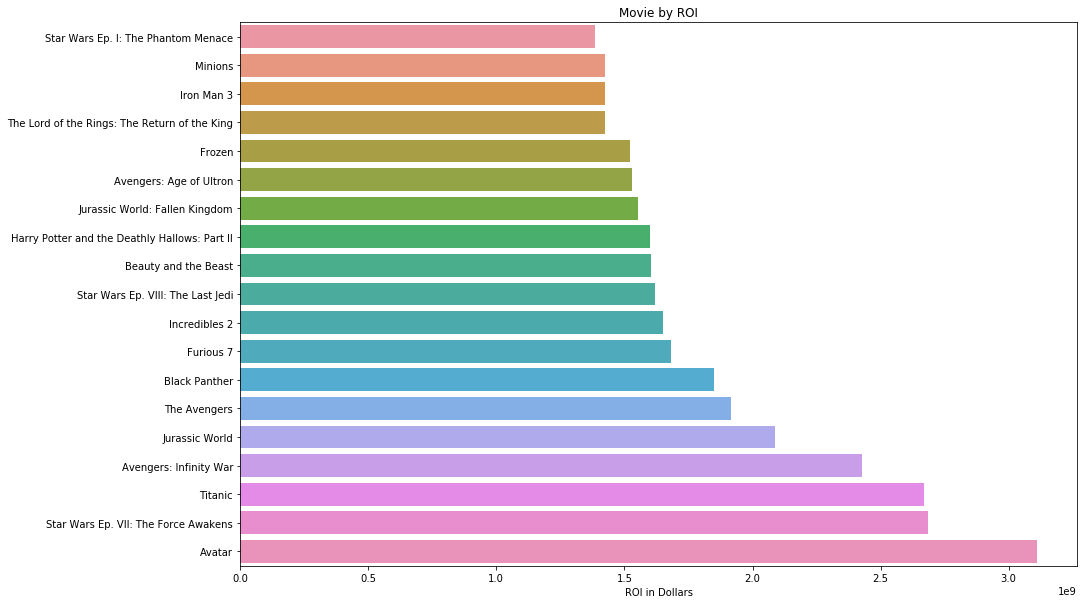

In [60]:
#Creates an ROI column for films and creates a column with a boolean value based on whether or not it's profitable
final_budget_df['ROI'] = final_budget_df['worldwide_gross'] + final_budget_df['domestic_gross'] - final_budget_df['production_budget']
budget_ROI_df = final_budget_df.sort_values(by='ROI',ascending=False)
budget_ROI_df['Profitable'] = budget_ROI_df.ROI.map(lambda x: x>0)


x_values = list(budget_ROI_df.title[:20])[::-1]
y_values = list(budget_ROI_df.ROI[:20])[::-1]

plt.figure(figsize=(15,10))
sns.barplot(y=x_values, x=y_values, data = final_budget_df, orient='h')
plt.xlabel('ROI in Dollars')
plt.title('Movie by ROI');

In [67]:
#Joins the TMDB table, which includes information regarding popularity by film.
tmdb_df['clean_title'] = tmdb_df.title.map(lambda x: clean_title(x))
tmdb_df['year'] = tmdb_df.release_date.map(lambda x: x.split('-')[0])
tmdb_df['clean_title'] = tmdb_df['clean_title'].str.cat(tmdb_df['year'],sep=' ')

tmdb_tconst_df = tmdb_df.merge(imdb_df,how='inner',on='clean_title')
tmdb_tconst_df.drop_duplicates(subset='title_id',inplace=True)
tmdb_clean_df = tmdb_tconst_df.loc[:, ['popularity','vote_average','vote_count','clean_title','title_id']]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13425 entries, 0 to 29759
Data columns (total 5 columns):
popularity      13425 non-null float64
vote_average    13425 non-null float64
vote_count      13425 non-null int64
clean_title     13425 non-null object
title_id        13425 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 629.3+ KB


/Users/andrew/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [70]:
#Creates Super_Df that contains ROI, popularity, IMDB rating and vote counts.
imdb_ratings_df.rename(columns={'tconst':'title_id'},inplace=True)
super_df = budget_ROI_df.merge(tmdb_clean_df,how='left',on='title_id')
super_df = super_df.merge(imdb_ratings_df,how='left',on='title_id')
super_df.drop(columns=['clean_title_y'],inplace=True)

Text(0.5, 1.0, 'ROI vs. Popularity')

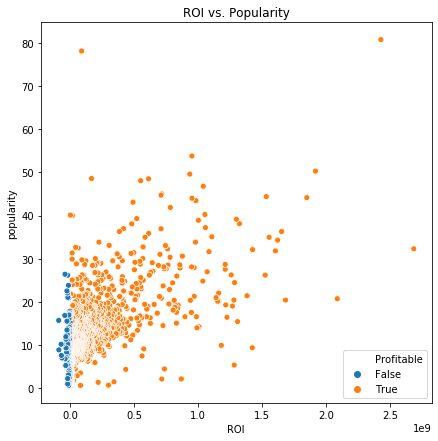

In [245]:
#Creates a scatter plot of ROI vs. Popularity
figure = plt.figure(figsize=(7,7))

sns.scatterplot(x=super_df.ROI,y=super_df.popularity, data=super_df, hue='Profitable')
plt.title('ROI vs. Popularity');

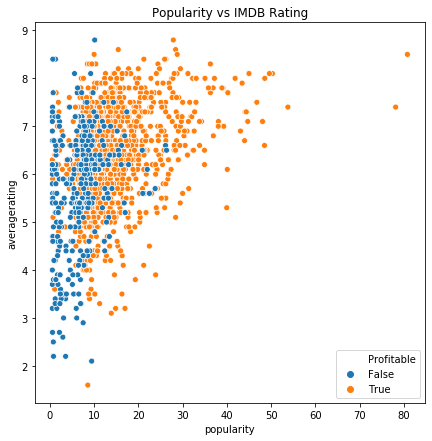

In [246]:
#Creates a scatterplot of popularity vs. IMDB Rating
figure = plt.figure(figsize=(7,7))

sns.scatterplot(x=super_df.popularity, y=super_df.averagerating, data=super_df, hue='Profitable')

plt.title('Popularity vs IMDB Rating');

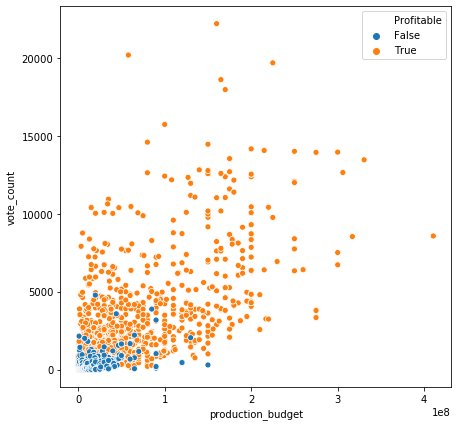

In [75]:
# Creates Scatterplot of Production Budget vs. IMDB Vote Count
figure = plt.figure(figsize=(7,7))

sns.scatterplot(x=super_df.production_budget, y=super_df.vote_count, data=super_df, hue='Profitable');

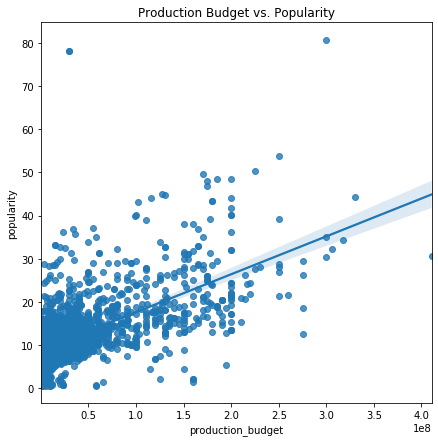

In [248]:
#Creates Linear Regression showing relationship between production budget and popularity
plt.figure(figsize=(7,7))

sns.regplot(x=super_df.production_budget, y=super_df.popularity, data=super_df)
plt.title('Production Budget vs. Popularity');

In [77]:
#Creates list of genres from the IMDB dataframes
genre_list = list(super_df.genres)
genre_list2 = []

#iterates through the list and adds the genres to a set to get a set of unique values
for item in genre_list:
    if type(item) == str:
        new_list = item.split(',')
        for genre in new_list:
            genre_list2.append(genre)

genre_set = set(genre_list2)


In [78]:
# drops 36 films that do not have genres
super_df.dropna(subset=['genres'],inplace=True)

In [80]:
# creates a column for each genre populated with a boolean value if it is in the genre list for that movie.
for genre in list(genre_set):
    super_df[f'{genre}'] = super_df.genres.map(lambda x: genre in x)

In [81]:
# splits the genres into a list, counts the list and adds a column with the number of genres in list
super_df['genres'] = super_df.genres.map(lambda x: separate_values(x))
super_df['genre_count'] = super_df.genres.map(lambda x: len(x))

In [82]:
# Groups by number of genres and giveds the mean popularity, rating and vote average
super_df[['ROI','popularity','averagerating','vote_average','genre_count']].groupby(by=['genre_count']).mean().sort_values(by='ROI')

,ROI,popularity,averagerating,vote_average
genre_count,,,,
1,4.979648e+07,8.359744,6.037915,6.060099
2,9.369759e+07,10.573929,6.207561,6.254198
3,1.979521e+08,14.638115,6.356218,6.311142


In [83]:
# Groups by number of genres and giveds the mean popularity, rating and vote average
super_df[['ROI','popularity','averagerating','vote_average','genre_count']].groupby(by=['genre_count']).median().sort_values(by='ROI')


,ROI,popularity,averagerating,vote_average
genre_count,,,,
1,3251244.0,8.3570,6.3,6.2
2,31750287.0,9.6200,6.3,6.3
3,75577726.0,12.7495,6.5,6.3


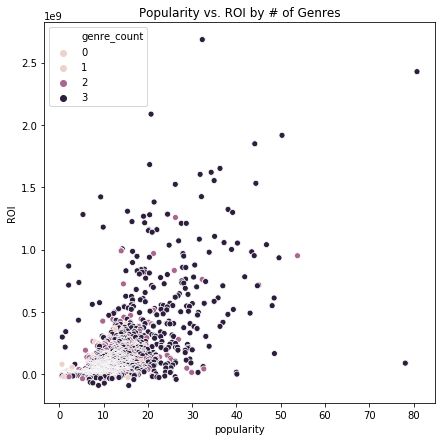

In [249]:
plt.figure(figsize=(7,7))

sns.scatterplot(x=super_df.popularity,y=super_df.ROI, data=super_df, hue='genre_count')
plt.title('Popularity vs. ROI by # of Genres');

In [250]:
#Creates separate dataframes for each genre count category for cleaning and manipulation
single_genre = super_df[['title','ROI','popularity','averagerating','vote_average','genre_count']].loc[super_df.genre_count == 1].sort_values(by=['ROI'],ascending=False)
double_genre = super_df[['title','ROI','popularity','averagerating','vote_average','genre_count']].loc[super_df.genre_count == 2].sort_values(by=['ROI'],ascending=False)
triple_genre = super_df[['title','ROI','popularity','averagerating','vote_average','genre_count']].loc[super_df.genre_count == 3].sort_values(by=['ROI'],ascending=False)


In [251]:
#Takes the top 50 entries per category
single_genre.drop_duplicates(subset=['title'],inplace=True)
single_short = single_genre.iloc[:50]

double_genre.drop_duplicates(subset=['title'],inplace=True)
double_short = double_genre.iloc[:50]

triple_genre.drop_duplicates(subset=['title'],inplace=True)
triple_short = triple_genre.iloc[:50]

In [252]:
#Joins the dataframes into a single dataframe with 50 entries per genre grouping
genre_df = pd.concat([single_short,double_short,triple_short])
genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 117 to 97
Data columns (total 6 columns):
title            150 non-null object
ROI              150 non-null float64
popularity       149 non-null float64
averagerating    147 non-null float64
vote_average     149 non-null float64
genre_count      150 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 8.2+ KB


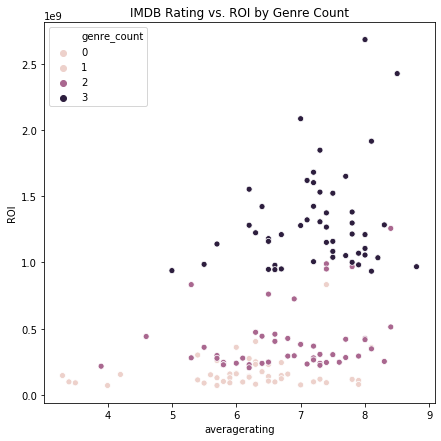

In [253]:
plt.figure(figsize=(7,7))

sns.scatterplot(x=genre_df.averagerating,y=genre_df.ROI,data=genre_df,hue='genre_count')

plt.title('IMDB Rating vs. ROI by Genre Count');

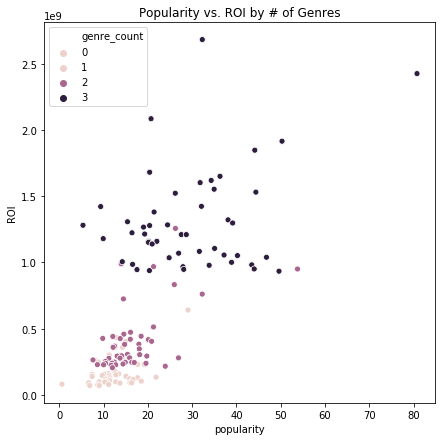

In [254]:
plt.figure(figsize=(7,7))

sns.scatterplot(x=genre_df.popularity,y=genre_df.ROI,data=genre_df,hue='genre_count')

plt.title('Popularity vs. ROI by # of Genres');

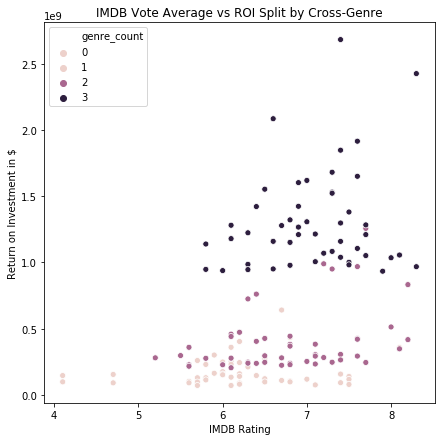

In [255]:
plt.figure(figsize=(7,7))

sns.scatterplot(x=genre_df.vote_average,y=genre_df.ROI,data=genre_df,hue='genre_count')
plt.title('IMDB Vote Average vs ROI Split by Cross-Genre')
plt.xlabel('IMDB Rating')
plt.ylabel('Return on Investment in $');

In [106]:
super_df['genre_list'] = super_df['genres']
super_df['genres'] = super_df.genres.map(lambda x: revert_genres(x))

In [127]:
super_df.numvotes.median()

57142.0

In [129]:
super_vote_df = super_df.loc[(super_df.vote_count > 500) & (super_df.numvotes > 30000)]

In [ ]:
super_df.loc[]

In [104]:
# def revert_genres(list):
    
#     string = ''
    
#     for item in list:
#         string += item + ','
        
#     string = string[:-1]
    
#     return string

In [263]:
def genre_counts(dataframe,column):
    '''
    Takes in a dataframe and a column. Orders the DF by the values in the column in question, cuts in down
    to the top 100 entries. Counts how many of the movies have each genre and then plots a horizontal
    bar graph to show top genres by the column metric. 
    '''
    df = dataframe.sort_values(by=[column],ascending=False)
    df = df.iloc[:100]
    df = pd.DataFrame(df[list(genre_set)].sum())
    df.columns = ['count']
    df.sort_values(by='count',ascending=False,inplace=True)
    plt.figure(figsize=(7,7))
    x_values = list(df['count'])
    y_values = list(df.index)
    plt.title(f'Genres ordered by {column}')
    plt.xlabel('Number of Movies')
    plt.ylabel('Genres')
    return sns.barplot(y=y_values,x=x_values, data=df, orient='h');

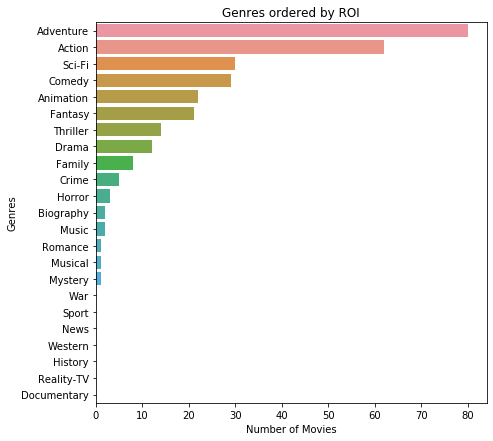

In [264]:
genre_counts(super_vote_df,'ROI')

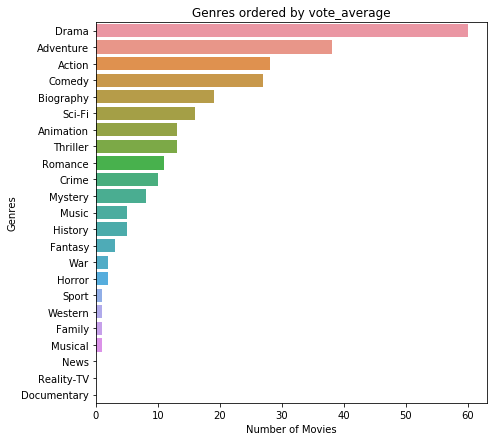

In [265]:
genre_counts(super_vote_df,'vote_average')

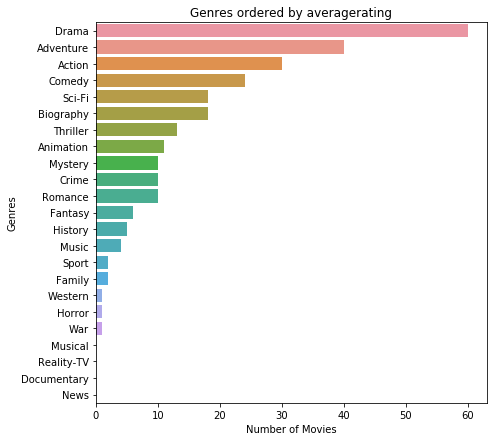

In [266]:
genre_counts(super_vote_df,'averagerating')

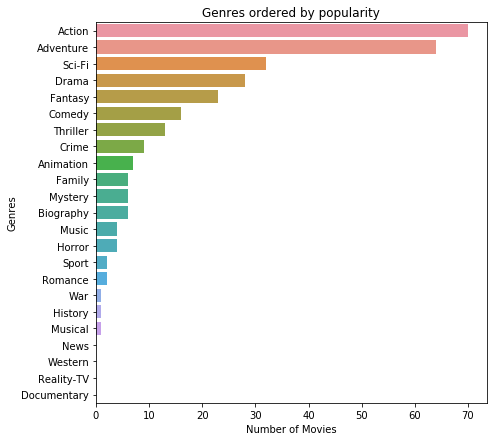

In [267]:
genre_counts(super_vote_df,'popularity')

In [197]:
#Builds new Dataframe using the IMDB data
clean_imdb_df = imdb_df.loc[imdb_df.primary_title == imdb_df.title]
clean_imdb_df = clean_imdb_df.merge(imdb_ratings_df, how='left', on='title_id')
clean_imdb_df.drop_duplicates(inplace=True)


In [164]:
directors_df.rename(columns={'tconst':'title_id'},inplace=True)

In [166]:
clean_imdb_df = clean_imdb_df.merge(directors_df, how='left', on='title_id')

In [204]:
#Creates a dataframe from the Crew Dataframe that only includes actors, actresses, producers, writers, directors

crew_df.rename(columns={'tconst':'title_id'},inplace=True)
non_directors_df = crew_df.loc[(crew_df.category == 'actor') | (crew_df.category == 'actress') | (crew_df.category == 'producer') | (crew_df.category == 'writer') | (crew_df.category == 'director')]

#Combines IMDB Dataframe with the slimmed Crew dataframe and only focuses on movies with more than 500 votes on IMDB
clean_imdb_df = non_directors_df.merge(clean_imdb_df, how='left', on='title_id')
clean_imdb_df = clean_imdb_df.loc[clean_imdb_df.numvotes > 500]

#Combines Dataframes to add names to crew members 
clean_imdb_df = clean_imdb_df.merge(professional_names_df, how='left', on='nconst')

#Drops useless columns
clean_imdb_df = clean_imdb_df.drop(columns=['job','characters','ordering','title','birth_year','death_year','primary_profession','known_for_titles'])

#Combines Dataframe with the TMDB dataframe that has already been cleaned
clean_imdb_df = clean_imdb_df.merge(tmdb_clean_df, how='left', on='title_id')

In [224]:
clean_imdb_df.groupby(by=clean_imdb_df['primary_name']).mean().sort_values(by='averagerating',ascending=False)



,year,runtime,averagerating,numvotes
primary_name,,,,
Lasha Kankava,2018.0,132.0,9.6,2604.0
Rezo Chkhikvishvili,2018.0,132.0,9.6,2604.0
Ana Tsereteli,2018.0,132.0,9.6,2604.0
Nikoloz Khomasuridze,2018.0,132.0,9.6,2604.0
Giorgi Megrelishvili,2018.0,132.0,9.6,2604.0
...,...,...,...,...
Ikuya Motoki,2013.0,82.0,1.0,510.0
Ayumu Saitô,2014.0,61.0,1.0,520.0
Yukichi Kobayashi,2014.0,61.0,1.0,520.0


In [241]:
#Creates different dataframes for each of the major crew types for further analysis. Treats actors and actresses equally
actors_mf_df = clean_imdb_df.loc[(clean_imdb_df.category == 'actor') | (clean_imdb_df.category == 'actress')]
directors2_df = clean_imdb_df.loc[clean_imdb_df.category == 'director']
writers_df = clean_imdb_df.loc[clean_imdb_df.category == 'writer']
producers_df = clean_imdb_df.loc[clean_imdb_df.category == 'producer']

In [231]:
def top_crew(dataframe,column):
    '''
    Takes a crew dataframe and finds the mean of the column metric in question and then plots a bar graph
    of the top fifty entries
    '''
    df = dataframe.groupby(by=dataframe['primary_name']).mean().sort_values(by=f'{column}',ascending=False)
    df = df.iloc[:50]
    plt.figure(figsize=(5,10))
    x_values = list(df[f'{column}'])
    y_values = list(df.index)
    return sns.barplot(x = x_values, y = y_values, data = df)

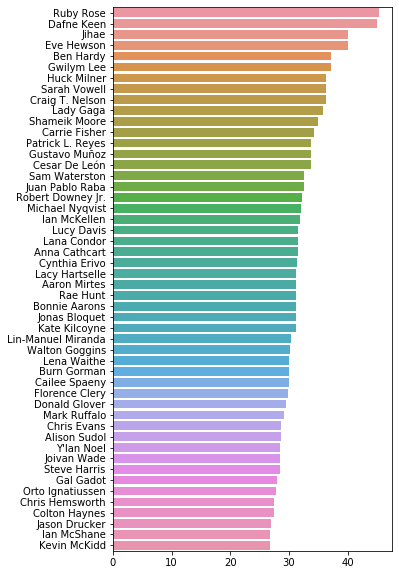

In [242]:
top_crew(actors_mf_df,'popularity')

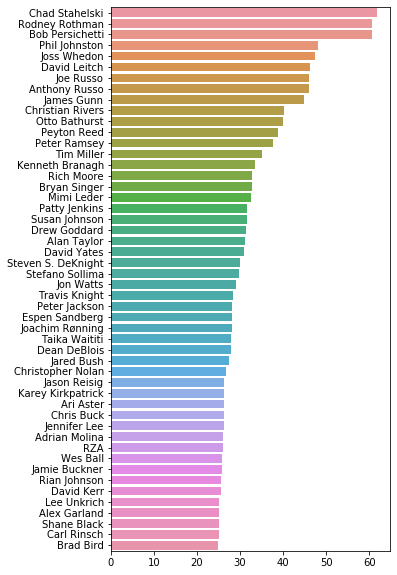

In [243]:
top_crew(directors2_df,'popularity')

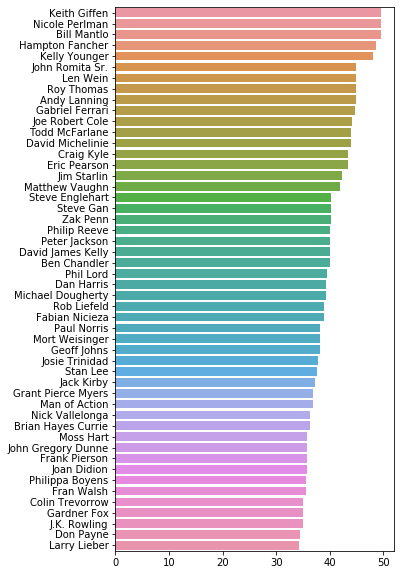

In [244]:
top_crew(writers_df,'popularity')

In [ ]:
# ADD ROI TO clean_imdb_df
# Analysis of the first TV shows/Movies from Netflix, Amazon, Hulu, HBO